<a href="https://colab.research.google.com/github/Lindronics/honours_project/blob/master/notebooks/classification/animals/Animal_classifier_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animal classifier

## Setup and imports



In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!rm -rf /content/*
!wget --no-check-certificate -O dataset.zip "https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21228202&authkey=ADau7jkkCZLnQ8k"
!unzip -q dataset.zip

--2020-02-23 10:40:52--  https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21228202&authkey=ADau7jkkCZLnQ8k
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://kusdwq.am.files.1drv.com/y4m79qw9M0JT5qQog2Uf9k9z8dG-vx0NEfLYSR4Jimz7tAmILJWSG-34n6MclKDt_uezskkRGg1YIxf-V6pxCiVqbdSEl3FNfkPQvonkDhPAKP7VqDxeuHwu597QJQa9g1-k9Y1WojKGeturadKiwvGnZezceQuhvLG9ZAjPyNKDFJOXtHCRLqsBum0CNQKg5ab1GI6EmcjAU3INjv-Q2BtqQ/images_160x120_downsampled.zip?download&psid=1 [following]
--2020-02-23 10:40:53--  https://kusdwq.am.files.1drv.com/y4m79qw9M0JT5qQog2Uf9k9z8dG-vx0NEfLYSR4Jimz7tAmILJWSG-34n6MclKDt_uezskkRGg1YIxf-V6pxCiVqbdSEl3FNfkPQvonkDhPAKP7VqDxeuHwu597QJQa9g1-k9Y1WojKGeturadKiwvGnZezceQuhvLG9ZAjPyNKDFJOXtHCRLqsBum0CNQKg5ab1GI6EmcjAU3INjv-Q2BtqQ/images_160x120_downsampled.zip?download&psid=1
Resolving kusdwq.am.fi

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns; sns.set()
import os
from os import listdir
from os.path import isdir, join
from tqdm import tqdm
from datetime import datetime

from itertools import count
from collections import defaultdict

In [0]:
from os import listdir
from os.path import isdir, join

class_whitelist = [
    "pony",
    "alpaca",
    "peacock",
    "chicken",
    "cat",
    "goose",
    "sheep",
]

configurations = {
    "medium": lambda fname: fname.split("_")[0] not in ["human", "evil-chicken", "ferret"],
    "cat": lambda fname: fname.split("_")[0] == "cat",
    "goose": lambda fname: fname.split("_")[0] == "goose",
    "pony": lambda fname: fname.split("_")[0] == "pony",
    "whitelist": lambda fname: fname.split("_")[0] in class_whitelist,
    "full": lambda x: True,
}

def generate_metadata(config, root="images"):
    """ Generates labels to be read by model data loader """

    classes = [c for c in listdir(root) if isdir(join(root, c))]
    samples = {c: 0 for c in classes}
    
    with open(f"labels_{config}.txt", "w") as f:
        for c in classes:
            batches = [b for b in listdir(join(root, c)) if isdir(join(root, c, b)) and configurations[config](b)]
            
            for b in batches:
                lwir_images = [i for i in listdir(join(root, c, b, "lwir")) if i.endswith(".png")]
                rgb_images = [i for i in lwir_images]

                lwir_paths = [join(root, c, b, "lwir", i) for i in lwir_images]
                rgb_paths = [join(root, c, b, "rgb", i) for i in rgb_images]

                for lwir_path, rgb_path in zip(lwir_paths, rgb_paths):
                    f.write(" ".join([rgb_path, lwir_path, c]) + "\n")
                    samples[c] += 1

    print("Dataset composition:")
    sum_ = 0
    for c, s in samples.items():
        sum_ += s
        print(f" - {c}: \t{s}")
    print(f"{sum_} items total.")

cfg = "full"
# root = "images_augmented"
root = "images_160x120_augmented"
generate_metadata(cfg, root=root)

Dataset composition:
 - pony: 	615
 - ugly-duck: 	615
 - alpaca: 	615
 - chicken: 	615
 - peacock: 	615
 - evil-chicken: 	615
 - rabbit: 	615
 - pig: 	615
 - ferret: 	615
 - cat: 	615
 - goose: 	615
 - pretty-chicken: 	615
 - sheep: 	615
7995 items total.


## Dataset

In [0]:
transformation = np.array([
    [1.202290, -0.026808, -50.528589],
    [0.017762, 1.203090, -73.950204],
])

class Dataset(K.utils.Sequence):

    def __init__(self, metadata, rgb_only=False, res=(480, 640), register=True, batch_size=16, train=True):

        self.rgb_only = rgb_only
        self.res = res
        self.register = register
        self.batch_size = batch_size

        self.classes = defaultdict(count().__next__)
        self.samples = []

        samples = []
        labels = []
        with open(metadata, "r") as f:
            for line in f:
                line = line.split()
                class_label = self.classes[line[-1]]
                samples.append(tuple(line[:2] + [class_label]))
                labels.append(class_label)

        train_data, test_data = train_test_split(samples, stratify=labels, test_size=0.2, random_state=42)
        self.samples = train_data if train else test_data

        self.class_dict = {key: val for val, key in self.classes.items()}
        self.class_labels = [val for key, val in sorted(self.class_dict.items())]

    def __len__(self):
        return len(self.samples) // self.batch_size
    

    def __iter__(self):
        return self


    def load(self, path, register=False):
        img = cv2.imread(path) / 255
        if register:
            img = cv2.resize(img, (480, 640))
            img = cv2.warpAffine(img, transformation, (480, 640))
        img = cv2.resize(img, self.res)
        return img


    def __getitem__(self, idx):
        if idx < self.__len__():
            X = []
            y = []
            for i in range(self.batch_size):
                rgb_path, lwir_path, label = self.samples[idx * self.batch_size + i]

                one_hot = np.zeros(self.num_classes())
                one_hot[label] = 1
                y.append(one_hot)

                rgb = self.load(rgb_path, register=self.register)

                if self.rgb_only:
                    X.append(rgb)
                else:
                    lwir = self.load(lwir_path, register=False)
                    lwir = np.mean(lwir, -1)[..., None]
                    stacked = np.dstack([rgb, lwir])
                    X.append(stacked)

            return np.array(X), np.array(y)
        else:
            raise StopIteration

    def get_labels(self):
        return np.array([sample[-1] for sample in self.samples])

    def num_classes(self):
        return len(self.classes)

    def shape(self):
        return self.res[::-1] + tuple([(3 if self.rgb_only else 4)])


train_data = Dataset(f"labels_{cfg}.txt", rgb_only=False, train=True, res=(120, 160))
test_data = Dataset(f"labels_{cfg}.txt", rgb_only=False, train=False, res=(120, 160))

In [0]:
X, y = train_data[0]

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
# print(X_train.shape)
# X_train = X
# y_train = y

i = 2
print(X.shape)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
# ax1.imshow(X[i, ..., 0], cmap="gray")
# ax2.imshow(y_train[i, ..., 0], cmap="gray")

(16, 160, 120, 4)


In [0]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Keras model

In [0]:
class ResidualBlock(K.layers.Layer):
    
    def __init__(self, kernel_size=3, **kwargs):
        self.kernel_size = kernel_size
        super(ResidualBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv1 = K.layers.Conv2D(filters=input_shape[-1], kernel_size=(1, 1), strides=1, padding="same")
        self.conv2 = K.layers.Conv2D(filters=input_shape[-1], kernel_size=self.kernel_size, strides=1, padding="same")
        self.batch_norm1 = K.layers.BatchNormalization()
        self.batch_norm2 = K.layers.BatchNormalization()
        self.activation = K.layers.ReLU()
        self.add = K.layers.Add()
        # self.dropout = K.layers.Dropout(0.4)

        super(ResidualBlock, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        x_shortcut = x
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.activation(x)
        x = self.add([x_shortcut, x])
        return x

    def compute_output_shape(self, input_shape):
        # return (input_shape[0], input_shape[1], input_shape[2], self.output_dim)
        return input_shape

## ResNet

In [0]:
model = K.Sequential()

model.add(K.layers.Input(shape=train_data.shape()))

model.add(K.layers.AvgPool2D(pool_size=2))

model.add(K.layers.Conv2D(filters=64, kernel_size=7, strides=2, activation="relu", padding="valid"))
model.add(K.layers.MaxPool2D(pool_size=2))

model.add(ResidualBlock(kernel_size=3))
model.add(ResidualBlock(kernel_size=3))
model.add(ResidualBlock(kernel_size=3))

model.add(K.layers.Conv2D(filters=128, kernel_size=7, strides=2, activation="relu", padding="valid"))
model.add(K.layers.MaxPool2D(pool_size=2))

model.add(ResidualBlock(kernel_size=3))
model.add(ResidualBlock(kernel_size=3))
model.add(ResidualBlock(kernel_size=3))

model.add(K.layers.Conv2D(filters=256, kernel_size=7, strides=2, activation="relu", padding="valid"))
model.add(K.layers.MaxPool2D(pool_size=2))

# model.add(ResidualBlock(kernel_size=3))
# model.add(ResidualBlock(kernel_size=3))
# model.add(ResidualBlock(kernel_size=3))



# model.add(K.layers.Conv2D(filters=8, kernel_size=5, strides=2, activation="relu", padding="same"))
# model.add(K.layers.Dropout(0.4))

# model.add(ResidualBlock())
# model.add(ResidualBlock())
# model.add(ResidualBlock())
# model.add(ResidualBlock())

# model.add(K.layers.Conv2D(filters=16, kernel_size=5, strides=2, activation="relu", padding="same"))
# model.add(K.layers.MaxPool2D(pool_size=2))
# model.add(K.layers.Dropout(0.4))

# # model.add(ResidualBlock())
# # model.add(ResidualBlock())
# # model.add(ResidualBlock())
# # model.add(ResidualBlock())

# model.add(K.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu", padding="same"))
# model.add(K.layers.MaxPool2D(pool_size=2))
# model.add(K.layers.Dropout(0.4))

# model.add(K.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu", padding="same"))
# model.add(K.layers.MaxPool2D(pool_size=2))
# model.add(K.layers.Dropout(0.4))

model.add(K.layers.Flatten())
model.add(K.layers.Dense(train_data.num_classes(), activation="softmax"))

model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
model.summary()

ValueError: ignored

## StuffNet

In [0]:
model = K.Sequential()

model.add(K.layers.Input(shape=train_data.shape()))

model.add(K.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same"))
model.add(K.layers.Conv2D(filters=16, kernel_size=11, strides=2, padding="valid"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.MaxPool2D(pool_size=11, strides=3))
model.add(K.layers.Dropout(0.4))

# Convolution 2
model.add(K.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same"))
model.add(K.layers.Conv2D(filters=32, kernel_size=7, strides=2, padding="valid"))
model.add(K.layers.LeakyReLU())
model.add(K.layers.MaxPool2D(pool_size=5, strides=2))
model.add(K.layers.Dropout(0.4))

# Convolution 3
# model.add(K.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="valid"))
# model.add(K.layers.LeakyReLU())
# model.add(K.layers.MaxPool2D(pool_size=4, strides=2))
# model.add(K.layers.Dropout(0.4))

# Flatten for fully connected
model.add(K.layers.Flatten())

# Fully connected 4
model.add(K.layers.Dense(64, activation="relu"))
model.add(K.layers.Dropout(0.4))

# Output layer
model.add(K.layers.Dense(train_data.num_classes(), activation="sigmoid"))

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 160, 120, 16)      592       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 75, 55, 16)        30992     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 75, 55, 16)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 22, 15, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 15, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 22, 15, 32)        4640      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 5, 32)         

## Train

In [0]:
# %reload_ext tensorboard
# %tensorboard --logdir logs/fit

In [0]:
# %%time
# !rm -rf logs
log_dir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)

# model.fit(train_data, epochs=10, callbacks=[tensorboard_callback], validation_data=test_data)

model.fit(train_data, epochs=15, validation_data=test_data)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 399 steps, validate for 99 steps
Epoch 1/15
399/399 [==============================] - 56s 140ms/step - loss: 2.4053 - accuracy: 0.1504 - val_loss: 2.0392 - val_accuracy: 0.4508
Epoch 2/15
399/399 [==============================] - 55s 137ms/step - loss: 1.9796 - accuracy: 0.2804 - val_loss: 1.6148 - val_accuracy: 0.5013
Epoch 3/15
399/399 [==============================] - 55s 137ms/step - loss: 1.7674 - accuracy: 0.3459 - val_loss: 1.5646 - val_accuracy: 0.4160
Epoch 4/15
399/399 [==============================] - 55s 138ms/step - loss: 1.5684 - accuracy: 0.4325 - val_loss: 1.2082 - val_accuracy: 0.6749
Epoch 5/15
399/399 [==============================] - 56s 141ms/step - loss: 1.3071 - accuracy: 0.5412 - val_loss: 0.7860 - val_accuracy: 0.7891
Epoch 6/15
399/399 [==============================] - 56s 141ms/step - loss: 1.0356 - accuracy: 0.6474 - val_loss: 0.5470 - val_accuracy: 0.8018
Epoch 7/15
399/399 [=================

In [0]:
model.save_weights('weights.h5')

In [0]:
model.load_weights("weights.h5")

In [0]:
y_pred = np.argmax(model.predict(test_data), axis=1)
y_test = test_data.get_labels()[:y_pred.shape[0]]
print(classification_report(y_test, y_pred, target_names=test_data.class_labels))

                precision    recall  f1-score   support

          pony       1.00      0.95      0.97       123
     ugly-duck       0.98      1.00      0.99       119
        alpaca       0.92      0.99      0.95       123
       chicken       0.86      0.92      0.89       123
       peacock       0.98      0.74      0.84       122
  evil-chicken       0.98      1.00      0.99       123
        rabbit       0.98      1.00      0.99       121
           pig       1.00      1.00      1.00       123
        ferret       0.99      1.00      1.00       120
           cat       1.00      1.00      1.00       121
         goose       0.92      0.98      0.95       122
pretty-chicken       1.00      1.00      1.00       122
         sheep       1.00      1.00      1.00       122

      accuracy                           0.97      1584
     macro avg       0.97      0.97      0.97      1584
  weighted avg       0.97      0.97      0.97      1584



In [0]:
# test_data.get_labels().shape
# np.argmax(y_pred, axis=1).shape

(1124,)

In [0]:
print("Pred:", np.bincount(y_pred))
print("True:", np.bincount(y_test))

Pred: [ 99 105  80  81  67 169 167]
True: [109 110 110 110 110 109 110]


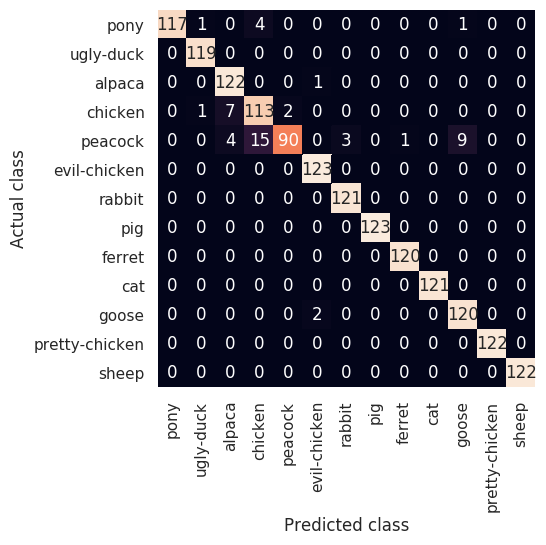

In [0]:
# y_pred = model.predict_classes(X_test)

y_pred_named = [test_data.class_labels[x] for x in y_pred]
y_test_named = [test_data.class_labels[x] for x in y_test]
confusion = confusion_matrix(y_test_named, y_pred_named, labels=test_data.class_labels)

f, ax = plt.subplots(figsize=(5, 5), dpi=100)
ax = sns.heatmap(confusion, annot=True, xticklabels=test_data.class_labels, yticklabels=test_data.class_labels, square=True, cbar=False, fmt="d")
ax.set(xlabel='Predicted class', ylabel='Actual class')
plt.show()

In [0]:
n = 5

ids = np.random.randint(0, len(test_data)-1, size=n)
preds = model.predict_classes(test_data[ids])

fig, axes = plt.subplots(1, n, figsize=(15, 10))

for id_, ax, pred in zip(ids, axes, preds):
    ax.imshow(X_test[id_][..., 1:])
    ax.axis('off')
    ax.set_title(data.class_labels[pred])

plt.tight_layout()

ValueError: ignored

defaultdict(<method-wrapper '__next__' of itertools.count object at 0x7f3ea2c8f6c8>,
            {'alpaca': 2, 'chicken': 4, 'peacock': 3, 'pig': 0, 'pony': 1})